In [298]:
import numpy as np
import pysindy as ps
import timeit
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from matplotlib import collections
import os
from shutil import rmtree
from IPython.display import Video
plt.rcParams.update({'font.size': 12, 'pdf.fonttype':42,'text.usetex': False, 'font.family': 'serif'})

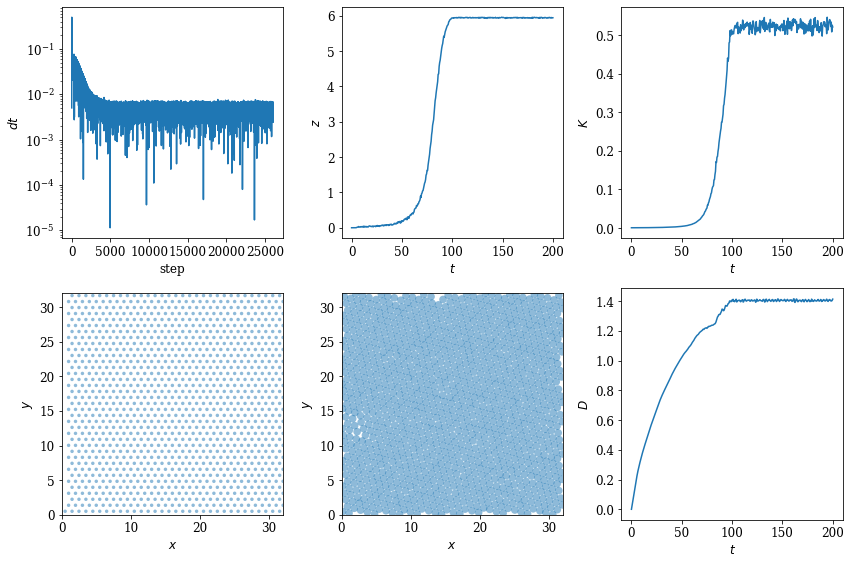

In [314]:
filebase='data/quasistatic'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)
file.close()
times=np.fromfile(filebase+'times.dat')
order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
states=np.fromfile(filebase+'states.dat')
states=states.reshape((int(len(states)/((2*dim)*N)),(2*dim)*N))
icoord=[]
jcoord=[]
ind=0
while ind<len(order):
    icoord.append(order[ind+1:ind+2*order[ind]+1:2])
    jcoord.append(order[ind+2:ind+2*order[ind]+1:2])
    ind=ind+2*order[ind]+1
coords= np.array([len(ind) for ind in icoord])/(N/2)

plt.subplots(2,3,figsize=(12,8))
plt.subplot(2,3,1)
plt.ylabel('$dt$')
plt.xlabel('step')
plt.yscale('log')
plt.plot(np.diff(times))
plt.subplot(2,3,2)
plt.ylabel('$z$')
plt.xlabel('$t$')
plt.plot(dt*np.arange(len(coords)),coords)
plt.subplot(2,3,4)
t=t3
Rt=R
if t<t2:
    Rt=R0+t/t2*(R-R0)
circles = [plt.Circle((x,y), radius=Rt) for (x,y) in zip(states[0,0::4],states[0,1::4])]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)
plt.subplot(2,3,5)
t=t1
Rt=R
if t<t2:
    Rt=R0+t/t2*(R-R0)
circles = [plt.Circle((x,y), radius=Rt) for (x,y) in zip(states[-1,0::4],states[-1,1::4])]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)

plt.subplot(2,3,3)
plt.xlabel('$t$')
plt.ylabel('$K$')
plt.plot(dt*np.arange(len(states)),np.mean(0.5*(states[:,2::4]**2+states[:,3::4]**2),axis=1))

plt.subplot(2,3,6)
plt.xlabel('$t$')
plt.ylabel('$D$')
plt.plot(dt*np.arange(len(states)), np.mean((np.mod(states[:,0::4]-states[0,0::4]+L/2,L)-L/2)**2+(np.mod(states[:,1::4]-states[0,1::4]+L/2,L)-L/2)**2,axis=1)**0.5)


plt.tight_layout()
plt.show()

In [315]:
skip=1
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
for i in range(int(len(states)/skip)):
    print(i, int(len(states)/skip),end='\r')
    t=t3+skip*i*(t1-t3)/int(len(states)/skip)
    Rt=R
    if t<t2:
        Rt=R0+t/t2*(R-R0)
    circles = [plt.Circle((x,y), radius=Rt) for (x,y) in zip(states[skip*i,0::4],states[skip*i,1::4])]
    circles2 = [plt.Circle((x,y), radius=R0) for (x,y) in zip(states[skip*i,0::4],states[skip*i,1::4])]
    plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
    plt.gca().add_collection(collections.PatchCollection(circles2,fc='red',alpha=0.5))
    plt.xlim(0,L)
    plt.ylim(0,L)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.gca().set_aspect(1)
    plt.savefig(filebase+'animation/'+str(i).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 15 ')
rmtree(filebase+'animation')
Video(filebase+'animation.mp4',width=512)

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

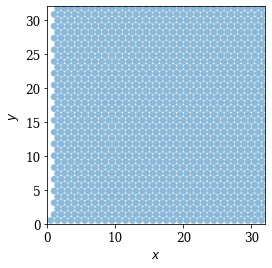

In [350]:
N=1166
R=0.5
V=0.1
xs=[]
ys=[]
x=R
y=R
for i in range(N):
    xs.append(x)
    ys.append(y)
    x=x+2*R
    if(x>L):
        y=y+3**0.5*R
        x=np.mod(x+R,L)

ic=np.concatenate(np.array([xs,ys,V*(np.random.random(N)-0.5),V*(np.random.random(N)-0.5)]).T)
circles = [plt.Circle((x,y), radius=R) for (x,y) in zip(ic[0::4],ic[1::4])]
plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
plt.xlim(0,L)
plt.ylim(0,L)
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.gca().set_aspect(1)
ic.tofile('data/latticeic.dat')

In [ ]:
plt.subplots(1,2,figsize=(8,4))
for i in range(1,21):
    filebase='data/lattice/'+str(i)
    file=open(filebase+'out.dat')
    N,dim,t1,t2,t3,dt,L,R0,R,V,H=file.readline().split()
    N=int(N)
    dim=int(dim)
    L=float(L)
    R0=float(R0)
    R=float(R)
    t1=float(t1)
    t2=float(t2)
    t3=float(t3)
    dt=float(dt)
    file.close()
    times=np.fromfile(filebase+'times.dat')
    order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
    states=np.fromfile(filebase+'states.dat')
    states=states.reshape((int(len(states)/((2*dim)*N)),(2*dim)*N))

    plt.subplot(1,2,1)
    plt.ylabel('$z$')
    plt.xlabel('$t$')
    plt.plot(dt*np.arange(len(order)),order/(N/2))
    plt.subplot(1,2,2)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$t$')
    plt.ylabel('$D$')
    plt.plot(dt*np.arange(len(states)), np.mean((np.mod(states[:,0::4]-states[0,0::4]+L/2,L)-L/2)**2+(np.mod(states[:,1::4]-states[0,1::4]+L/2,L)-L/2)**2,axis=1)**0.5)
    
plt.tight_layout()
plt.show()

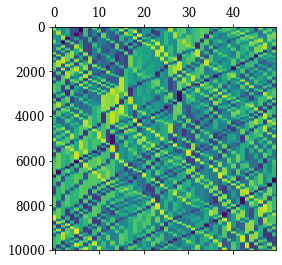

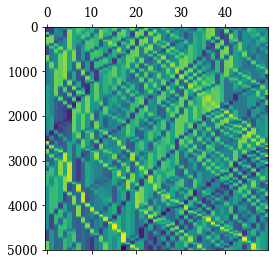

In [342]:
filebase='data/1d3'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)
file.close()
times=np.fromfile(filebase+'times.dat')
order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
states=np.fromfile(filebase+'states.dat')
states=states.reshape((int(len(states)/((2*dim)*N)),(2*dim)*N))
for i in range(int(N/4)):
    states[:,2*i]=np.mod(states[:,2*i]+L/2,L)-L/2
for i in range(int(3*N/4),N):
    states[:,2*i]=np.mod(states[:,2*i]-L/2,L)+L/2
    
test=np.fromfile("data/test.dat")
test2=test.reshape((50,5001,2))
R=1
dt=0.01
order=np.argsort(test2[:,0,0])
X=np.transpose([test2[order,:,0],test2[order,:,1]],axes=(1,0,2)).reshape(len(test2)*2,test2.shape[1]).T
plt.matshow(states[:,1::2],aspect=len(states[0])/len(states)/2)
plt.show()
plt.matshow(X[:,1::2],aspect=len(X[0])/len(X)/2)
plt.show()

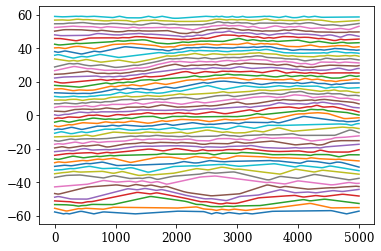

/home/zackn/.conda/envs/newton_env/lib/python3.9/site-packages/pysindy/optimizers/stlsq.py:190: ConvergenceWarning: STLSQ._reduce did not converge after 20 iterations.
  warnings.warn(


x0' = 0.996 f0(x1)
x1' = -2181.925 f0(x0) + 56.189 f0(x1) + -113.977 f0(x2) + 1.468 f0(x3) + 197.451 f0(x4) + -35.952 f0(x5) + 261.640 f0(x6) + -115.469 f0(x7) + 2.496 f0(x8) + 50.817 f0(x9) + 1106.987 f0(x10) + 379.416 f0(x11) + 432.262 f0(x12) + 42.669 f0(x13) + 494.329 f0(x14) + 363.744 f0(x15) + 551.744 f0(x16) + 159.476 f0(x17) + -74.931 f0(x18) + -205.904 f0(x19) + -722.345 f0(x20) + -15.596 f0(x21) + -104.267 f0(x22) + -221.897 f0(x23) + -75.055 f0(x24) + -98.758 f0(x25) + 750.442 f0(x26) + 93.744 f0(x27) + -958.603 f0(x28) + 147.659 f0(x29) + 474.285 f0(x30) + -43.564 f0(x31) + -1514.988 f0(x32) + -32.948 f0(x33) + -1747.466 f0(x34) + 44.955 f0(x35) + -106.787 f0(x36) + -84.904 f0(x37) + -1866.792 f0(x38) + -11.851 f0(x39) + 60.070 f0(x40) + 35.027 f0(x41) + -150.650 f0(x42) + -54.166 f0(x43) + -448.279 f0(x44) + -25.773 f0(x45) + -1206.774 f0(x46) + 128.357 f0(x47) + -76.293 f0(x48) + -64.283 f0(x49) + 1819.448 f0(x50) + -85.301 f0(x51) + -71.749 f0(x52) + -125.746 f0(x53) + 1

In [370]:
test=np.fromfile("data/test.dat")
test2=test.reshape((50,5001,2))
R=1
dt=0.01
order=np.argsort(test2[:,0,0])
X=np.transpose([test2[order,:,0],test2[order,:,1]],axes=(1,0,2)).reshape(len(test2)*2,test2.shape[1]).T
plt.plot(X[:,::2])
plt.show()
def iden (x):
    return x
def pairwise (x,y):
    d=y-x
    return [ (1-np.linalg.norm(d[i])/(2*R))**1.5 if np.linalg.norm(d[i])<2*R else 0 for i in range(len(d)) ]
def boundary1 (x):
    y=60-R/2
    d=y-x
    return [ (1-np.linalg.norm(d[i])/(R))**1.5 if np.linalg.norm(d[i])<R else 0 for i in range(len(d)) ]
def boundary2 (x):
    y=-(60-R/2)
    d=y-x
    return [ (1-np.linalg.norm(d[i])/(R))**1.5 if np.linalg.norm(d[i])<R else 0 for i in range(len(d)) ]

library_functions = [iden,pairwise,boundary1,boundary2]
custom_library = ps.CustomLibrary(library_functions=library_functions)
model = ps.SINDy(feature_library=custom_library)
start=timeit.default_timer()
model.fit(X, t=np.arange(0,len(X))*dt)
stop=timeit.default_timer()
model.print()
print(stop-start)

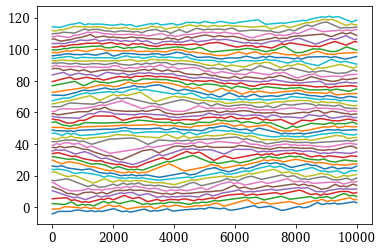

x0' = 1.000 f1(x1)
x1' = 9.999 f0(x0,x2) + 9.999 f0(x0,x98)
x2' = 1.000 f1(x3)
x3' = -9.999 f0(x0,x2) + 9.999 f0(x2,x4)
x4' = 1.000 f1(x5)
x5' = -9.999 f0(x2,x4) + 9.999 f0(x4,x6)
x6' = 1.000 f1(x7)
x7' = -9.999 f0(x4,x6) + 9.999 f0(x6,x8)
x8' = 1.000 f1(x9)
x9' = -9.999 f0(x6,x8) + 9.999 f0(x8,x10)
x10' = 1.000 f1(x11)
x11' = -9.999 f0(x8,x10) + 9.999 f0(x10,x12)
x12' = 1.000 f1(x13)
x13' = -9.999 f0(x10,x12) + 9.999 f0(x12,x14)
x14' = 1.000 f1(x15)
x15' = -9.999 f0(x12,x14) + 9.999 f0(x14,x16)
x16' = 1.000 f1(x17)
x17' = -9.999 f0(x14,x16) + 9.999 f0(x16,x18)
x18' = 1.000 f1(x19)
x19' = -9.999 f0(x16,x18) + 9.999 f0(x18,x20)
x20' = 1.000 f1(x21)
x21' = -9.999 f0(x18,x20) + 9.999 f0(x20,x22)
x22' = 1.000 f1(x23)
x23' = -9.999 f0(x20,x22) + 9.999 f0(x22,x24)
x24' = 1.000 f1(x25)
x25' = -9.999 f0(x22,x24) + 9.999 f0(x24,x26)
x26' = 1.000 f1(x27)
x27' = -9.999 f0(x24,x26) + 9.999 f0(x26,x28)
x28' = 1.000 f1(x29)
x29' = -9.999 f0(x26,x28) + 9.999 f0(x28,x30)
x30' = 1.000 f1(x31)
x31' = -9

In [371]:
filebase='data/1d3'
file=open(filebase+'out.dat')
N,dim,t1,t2,t3,dt,L,R0,R,V,H=file.readline().split()
N=int(N)
dim=int(dim)
L=float(L)
R0=float(R0)
R=float(R)
t1=float(t1)
t2=float(t2)
t3=float(t3)
dt=float(dt)
file.close()
times=np.fromfile(filebase+'times.dat')
order=np.fromfile(filebase+'orders.dat',dtype=np.int32)
states=np.fromfile(filebase+'states.dat')
states=states.reshape((int(len(states)/((2*dim)*N)),(2*dim)*N))
for i in range(int(N/4)):
    states[:,2*i]=np.mod(states[:,2*i]+L/2,L)-L/2
for i in range(int(3*N/4),N):
    states[:,2*i]=np.mod(states[:,2*i]-L/2,L)+L/2

icoord=[]
jcoord=[]
ind=0
while ind<len(order):
    icoord.append(order[ind+1:ind+2*order[ind]+1:2])
    jcoord.append(order[ind+2:ind+2*order[ind]+1:2])
    ind=ind+2*order[ind]+1
coords= np.array([len(ind) for ind in icoord])/(N/2)
plt.plot(states[:,::2])
plt.show()

def iden (x):
    return x
def pairwise (x,y):
    d=np.mod(x-y+L/2,L)-L/2
    return [ np.sign(d[i])*(1-np.linalg.norm(d[i])/(2*R))**1.5 if np.linalg.norm(d[i])<2*R else 0 for i in range(len(d)) ]

states.shape
library_functions = [pairwise,iden]
custom_library = ps.CustomLibrary(library_functions=library_functions)
model = ps.SINDy(feature_library=custom_library)
start=timeit.default_timer()
model.fit(states, t=np.arange(0,len(states))*dt)
stop=timeit.default_timer()
model.print()
print(stop-start)

In [309]:
N=50
L=120
V=1.0
vel=2*V*(np.random.random(N)-0.5)
ic=np.transpose([np.arange(N)*L/N,vel-np.mean(vel)]).reshape((2*N))
print(ic)
ic.tofile('data/1d3ic.dat')

[ 0.00000000e+00  4.48024633e-02  2.40000000e+00  5.37391261e-01
  4.80000000e+00 -3.36778109e-01  7.20000000e+00  3.51922067e-01
  9.60000000e+00 -3.91546601e-01  1.20000000e+01  4.69273174e-01
  1.44000000e+01 -5.48511214e-01  1.68000000e+01  2.85106843e-01
  1.92000000e+01 -4.86509560e-01  2.16000000e+01 -5.02234711e-01
  2.40000000e+01 -5.72691394e-01  2.64000000e+01 -6.22875679e-01
  2.88000000e+01  9.01890763e-01  3.12000000e+01 -1.36202684e-01
  3.36000000e+01 -8.89854612e-01  3.60000000e+01 -7.82796158e-01
  3.84000000e+01 -5.99006560e-01  4.08000000e+01  3.39111939e-02
  4.32000000e+01 -5.45381353e-01  4.56000000e+01  1.54226501e-01
  4.80000000e+01  6.04591541e-01  5.04000000e+01  8.57182204e-01
  5.28000000e+01  3.89940948e-01  5.52000000e+01 -6.31994733e-01
  5.76000000e+01 -7.29123332e-01  6.00000000e+01  3.75311060e-01
  6.24000000e+01  7.27821681e-01  6.48000000e+01 -3.09670568e-01
  6.72000000e+01 -8.51635589e-01  6.96000000e+01 -2.64681723e-02
  7.20000000e+01  1.04728

In [313]:
skip=10
if os.path.isdir(filebase+'animation'):
    rmtree(filebase+'animation')
if not os.path.isdir(filebase+'animation'):
    os.mkdir(filebase+'animation')
    
for i in range(int(len(states)/skip)):
    print(i, int(len(states)/skip),end='\r')
    circles=[plt.Circle((x,0),radius=R) for x in states[i*skip, ::2]]
    plt.gca().add_collection(collections.PatchCollection(circles,alpha=0.5))
    plt.xlim(0,L)
    plt.ylim(-L/2,L/2)
    plt.gca().set_aspect(1)
    plt.xlabel('$x$')
    plt.ylabel('$y$')
    plt.savefig(filebase+'animation/'+str(i).zfill(4)+'.png', dpi=200,bbox_inches='tight')
    plt.close('all')
    
os.system('./encode.sh ' + filebase+'animation/' + ' '  + filebase+'animation 15 ')
rmtree(filebase+'animation')
Video(filebase+'animation.mp4',width=512)

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l